In [2]:
import os
import sys

import numpy as np
from uncertainties import ufloat
from uncertainties.umath import *
import uncertainties.unumpy as unp 

from astropy.io.fits import getdata
from astropy import wcs
from astropy.io import fits
from astropy import units as u
from astropy import constants as con
from astropy.coordinates import SkyCoord

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib

import aplpy

import math
from scipy.interpolate import interp1d

#matplotlib.use('PDF')

from __future__ import print_function
from scipy.optimize import curve_fit

import utils as ut

deg_to_rad = 0.0174533
rad_to_deg = 57.2958
arcsec_to_arcmin = 0.0166667
deg_to_arcsec = 3600

In [3]:
def dataSelection(xlower, ylower, xupper, yupper, PA, err, PI):
    xlower = xlower
    ylower = ylower
    xupper = xupper
    yupper = yupper

    PAcenter = []
    PAcenter_nonan = [] 

    for x in range(xlower, xupper, 1):
        for y in range(ylower, yupper, 1):
            PA_list = [x, y, PA[y][x], err[0][y][x], PI[y][x]]
            PAcenter.append(PA_list)    
            
    # turning the list into an numpy array so we can use isnan to filter out the nan values
    for i in range(len(PAcenter)):
        if math.isnan(PAcenter[i][2]) == False:
            PA_nonan = [PAcenter[i][0], PAcenter[i][1], PAcenter[i][2], PAcenter[i][3], PAcenter[i][4]]
            PAcenter_nonan.append(PA_nonan)

    # Outputting to data file just for checking  
    outputFile1 = open("houde_array_nonan.tab", "w")
    for i in range(len(PAcenter_nonan)):
        print(PAcenter_nonan[i][0], PAcenter_nonan[i][1], PAcenter_nonan[i][2], PAcenter_nonan[i][3], PAcenter_nonan[i][4], sep='\t', file=outputFile1)
    outputFile1.close()    

    return PAcenter_nonan

In [4]:
def calculate_dispersion(pixel_size, bmaj, bmin, data):
    '''
    input:
    pixel_size [arcsec]
    bmaj       [deg]
    bmin       [deg]

    output:
    PA_vs_ellarcsec: a 6D array storing all the information needed to calculate the dispersion function and its errors
    '''
    PA_vs_ellarcsec = []
    uncertainty = []
    cosDeltaPhi_list = []
    linerr_anglecorr = []
    pixel_size = pixel_size # arcsecond
    W = np.sqrt(bmaj*deg_to_arcsec*bmin*deg_to_arcsec)/np.sqrt(8*math.log(2))  # beam "radius"

    print("The pixel size used is ", pixel_size, "arcsecond")
    print("bmaj is", bmaj*deg_to_arcsec, "arcsec" and "bmin is", bmin*deg_to_arcsec, "arcsec")
    print("The beam radius is hence", W, "arcsec")
 
    for i in range(len(data)):
        for j in range(i, len(data), 1):
            # delta PA constrained to [0, 90] deg 
            deltaPAij = abs(data[j][2] - data[i][2])
            if deltaPAij > 90 or deltaPAij == 90:
                deltaPAij = 180 - deltaPAij           

            # distance in pixel between 2 pixels 
            ell_pixelij = np.sqrt((data[i][0]-data[j][0])**2 + (data[i][1]-data[j][1])**2)
            
            # distance in arcsecond between 2 pixels
            ell_arcsecij = ell_pixelij * pixel_size

            # delta PA uncertainty for every pairs of delta PA
            deltaPAij_err_sqaure = data[i][3]**2 + data[j][3]**2 - 2*data[i][3]*data[j][3]*np.exp(-(ell_arcsecij**2)/(4*(W**2)))
            deltaPAij_err = np.sqrt(deltaPAij_err_sqaure)

            # P^2(l) = P(r)P(r+l) 
            deltaPIij = data[j][4]*data[i][4]      
            
            # putting all the deltaPA values with their corresponding ell into a 2D array
            # [k][0] is ell in arcsec, [k][1] is the deltaPA in degree
            # [k][2] is the cos(deltaPA), [k][3] is the error correction term, 
            # [k][4] is sin(deltaPA) for error bars, [k][5] is sqaure of the error of deltaPA in radian 
            sublistellvsPA = [ell_arcsecij, deltaPAij, np.cos(deltaPAij*deg_to_rad), np.cos(deltaPAij_err*deg_to_rad), np.sin(deltaPAij*deg_to_rad), deltaPAij_err_sqaure*(deg_to_rad*deg_to_rad), deltaPIij]
            PA_vs_ellarcsec.append(sublistellvsPA)

            #using uncertainty package 
            phi1 = ufloat(data[j][2]*deg_to_rad, data[j][3]*deg_to_rad)
            phi2 = ufloat(data[i][2]*deg_to_rad, data[i][3]*deg_to_rad)
            DeltaPhi = abs(phi1 - phi2)
            if DeltaPhi > (math.pi/2.0) or DeltaPhi == (math.pi/2.0):
                DeltaPhi = (math.pi) - DeltaPhi 
            cosDeltaPhi = cos(DeltaPhi)
            cosDeltaPhi_list.append(cosDeltaPhi)
            sublistuncertainty = [ell_arcsecij, np.cos(deltaPAij*deg_to_rad), cosDeltaPhi.n, cosDeltaPhi.s]
            uncertainty.append(sublistuncertainty)

            #linear error propagation with angle correlation taken into consideration 
            deltaPAij_err_anglecorr = (deltaPAij_err_sqaure*deg_to_rad*deg_to_rad)*(np.sin(deltaPAij*deg_to_rad)**2) 
            linerr_anglecorr.append([ell_arcsecij, cosDeltaPhi.s**2, deltaPAij_err_anglecorr])

    with open("PA_vs_ellarcsec.tab", "w") as outputFile:
        outputFile.writelines('\t'.join(map(str, sublist)) + '\n' for sublist in PA_vs_ellarcsec)

    with open("uncertainty.tab", "w") as outputFile:
        outputFile.writelines('\t'.join(map(str, sublist)) + '\n' for sublist in uncertainty)

    with open("uncertainty_linerr_anglecorr.tab", "w") as outputFile:
        outputFile.writelines('\t'.join(map(str, sublist)) + '\n' for sublist in linerr_anglecorr)    

    print("The expected number of pair of pixel is ", (len(data)*(len(data)-1))/2+len(data))
    print("The sampled number of pair of pixel is ", len(PA_vs_ellarcsec))

    return PA_vs_ellarcsec, uncertainty, cosDeltaPhi_list, linerr_anglecorr


In [5]:
def ell_binning(ell, bins):
   
    ell = np.asarray(ell)
    # bin size is chosen such that the width of each bin is around one pixel 
    #bins = math.ceil(max(PA_vs_ellarcsec)/pixel_size)
    count, ellbin = np.histogram(ell, bins = bins) 
    print(ellbin)
    print(count)

    return ellbin

In [6]:
def value_binning(ellbin, ell, value):

    value_bin = [] # our data

    for index in range(len(ellbin)):
        # resetting all sublist used to 0 at the start of every bin
        sublist_value_bin = []
        if index < (len(ellbin)-2): 
            for i in range(len(ell)):
                if (ell[i] >= ellbin[index] and ell[i] < ellbin[index+1]):
                    sublist_value_bin.append(value[i])
            #print(ellbin[index], len(sublist_value_bin))        
            value_bin.append(sublist_value_bin) 

            
        if index == (len(ellbin)-2): 
            for i in range(len(ell)):
                if (ell[i] >= ellbin[index] and ell[i] <= ellbin[index+1]):
                    sublist_value_bin.append(value[i])
            #print(ellbin[index], len(sublist_value_bin))        
            value_bin.append(sublist_value_bin)  

    return value_bin

## Driver code 

In [7]:
# importing PA, PAerr and PI data 
PA = ut.FITSimage('G31p4_Qband_D.rob2.PA.image.tt0.miriad.dropdeg.fits')
PA.FITSdata()
PAerr = ut.FITSimage('G31_JVLA_PA4.error.miriad.fit')
PAerr.FITSdata()
PI = ut.FITSimage('G31p4_Qband_D.rob2.PI.image.tt0.miriad.dropdeg.fits')
PI.FITSdata()

print(PAerr.data[0][224][222])

bmaj is 0.0007631573244 degree
bmaj is 0.0007631573244 degree
bmaj is 0.0007631573244 degree
6.1753755


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [8]:
# data selection: central and non-nan data
datatable = dataSelection(222, 224, 254, 259, PA.data, PAerr.data, PI.data)
print(datatable[:5])
print(len(datatable))

[[222, 224, -23.938036, 6.1753755, 0.00023195261], [222, 225, -18.434185, 6.5076437, 0.00022010953], [222, 226, -13.64847, 6.7285, 0.00021288467], [222, 227, -10.190204, 6.948227, 0.00020615252], [222, 228, -7.909552, 7.3771286, 0.00019416695]]
1024


In [9]:
# calculating distance, deltaPA and errors
PA_vs_ell, uncertainty, cosDeltaPhi_list, linerr_anglecorr = calculate_dispersion(0.3, PA.bmaj, PA.bmin, datatable)

The pixel size used is  0.3 arcsecond
bmaj is 2.74736636784 bmin is 1.6171657363872 arcsec
The beam radius is hence 0.895112929391518 arcsec
The expected number of pair of pixel is  524800.0
The sampled number of pair of pixel is  524800


In [10]:
# extracting columns of data from the data table from calculate_dispersion()
PA_vs_ell = np.asarray(PA_vs_ell)
ell = PA_vs_ell[:,0]
deltaPA = PA_vs_ell[:,1]
cos_deltaPA = PA_vs_ell[:,2]
cos_err_deltaPA = PA_vs_ell[:,3]
sin_deltaPA = PA_vs_ell[:,4]
deltaPA_err_sqaure = PA_vs_ell[:,5]
PI = PA_vs_ell[:,6]

linerr_anglecorr = np.asarray(linerr_anglecorr)
linerr_anglecorr_sigmaCosSquare = linerr_anglecorr[:,2]

# binning distance and hence sort the data calculated in the previous step according to the binned distance 
ell = PA_vs_ell[:,0]
ellbin = ell_binning(ell, 47)
cos_deltaPA_bin = value_binning(ellbin, ell, cos_deltaPA)
cos_err_deltaPA_bin = value_binning(ellbin, ell, cos_err_deltaPA)
sin_deltaPA_bin = value_binning(ellbin, ell, sin_deltaPA)
deltaPA_err_sqaure_bin = value_binning(ellbin, ell, deltaPA_err_sqaure)
linerr_anglecorr_sigmaCosSquare_bin = value_binning(ellbin, ell, linerr_anglecorr_sigmaCosSquare)

# binning PI
ellbinPI = ell_binning(ell, 10)
PI_square_bin = value_binning(ellbinPI, ell, PI)


[ 0.          0.29368639  0.58737279  0.88105918  1.17474557  1.46843197
  1.76211836  2.05580475  2.34949115  2.64317754  2.93686393  3.23055033
  3.52423672  3.81792311  4.11160951  4.4052959   4.69898229  4.99266869
  5.28635508  5.58004147  5.87372787  6.16741426  6.46110065  6.75478705
  7.04847344  7.34215983  7.63584623  7.92953262  8.22321901  8.51690541
  8.8105918   9.10427819  9.39796459  9.69165098  9.98533737 10.27902376
 10.57271016 10.86639655 11.16008294 11.45376934 11.74745573 12.04114212
 12.33482852 12.62851491 12.9222013  13.2158877  13.50957409 13.80326048]
[ 1024  3879  7355  8803 10138 16016 13821 17560 16831 17437 20369 24059
 19404 23598 20306 24614 20466 21576 21563 20677 19714 20442 19116 17763
 15965 13898 16196 11638 11785  9804  8387  8076  5809  4416  3736  2328
  1835  1346   907   864   440   425   191   108    94    15     6]
[ 0.          1.38032605  2.7606521   4.14097815  5.52130419  6.90163024
  8.28195629  9.66228234 11.04260839 12.42293444 13.803

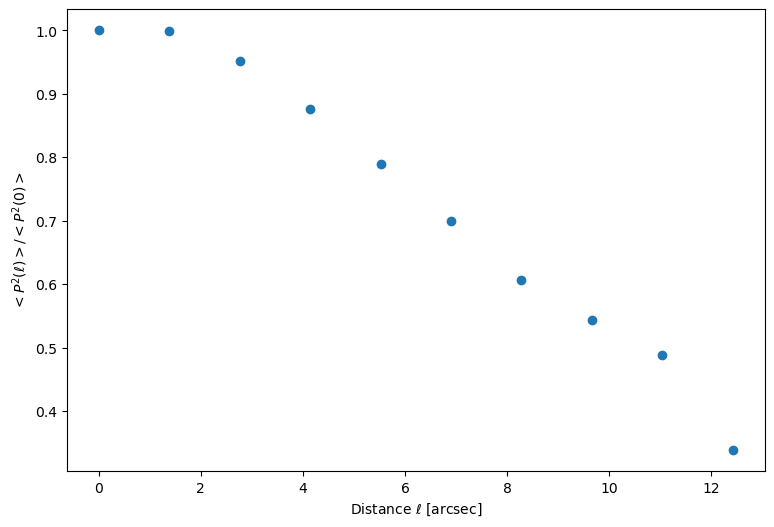

Like in Houde 2009, the distance corresponding to half of the correlation function is taken arbitarily to be the effective cloud depth
The effective cloud depth is 10.5 arcsec, the coressponding normalized PI correlation function is  0.50994576540876


In [11]:
# Caluclting cloud depth using polarization percentage
#ellPI_plot = ellbinPI[:len(ellbinPI)-1] + (ellbinPI[1] - ellbinPI[0])/2.0
ellPI_plot = ellbinPI[:len(ellbinPI)-1]

avg_P_sqaure = []
for i in range(len(PI_square_bin)):
    avg_P_sqaure.append(np.mean(PI_square_bin[i]))

normalizedPIsquare = avg_P_sqaure/avg_P_sqaure[0]

fig = plt.figure(figsize=(9,6))
plt.xlabel(r'$ \mathrm{Distance}\/\/ \ell\/\/ [\mathrm{arcsec}]$')
plt.ylabel(r'$<P^2(\ell)>/<P^2(0)>$')
plt.scatter(ellPI_plot, normalizedPIsquare)
plt.savefig("fig/PI_autocorrelation.pdf", transparent=True)
plt.show() 

# Finding the distance corresponding to ratio = 0.5
f = interp1d(ellPI_plot, normalizedPIsquare)
trial_distance = 10.5
ratio = f(trial_distance)
print("Like in Houde 2009, the distance corresponding to half of the correlation function is taken arbitarily to be the effective cloud depth")
print("The effective cloud depth is", trial_distance, "arcsec, the coressponding normalized PI correlation function is ", ratio)


### Case 1: Calculating measurement uncertainties by following Houde 2009

[ 0.          0.29368639  0.58737279  0.88105918  1.17474557  1.46843197
  1.76211836  2.05580475  2.34949115  2.64317754  2.93686393  3.23055033
  3.52423672  3.81792311  4.11160951  4.4052959   4.69898229  4.99266869
  5.28635508  5.58004147  5.87372787  6.16741426  6.46110065  6.75478705
  7.04847344  7.34215983  7.63584623  7.92953262  8.22321901  8.51690541
  8.8105918   9.10427819  9.39796459  9.69165098  9.98533737 10.27902376
 10.57271016 10.86639655 11.16008294 11.45376934 11.74745573 12.04114212
 12.33482852 12.62851491 12.9222013  13.2158877  13.50957409]


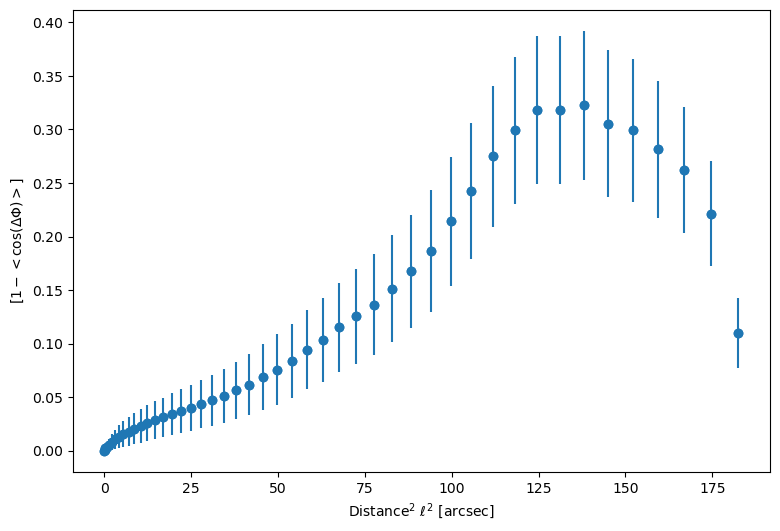

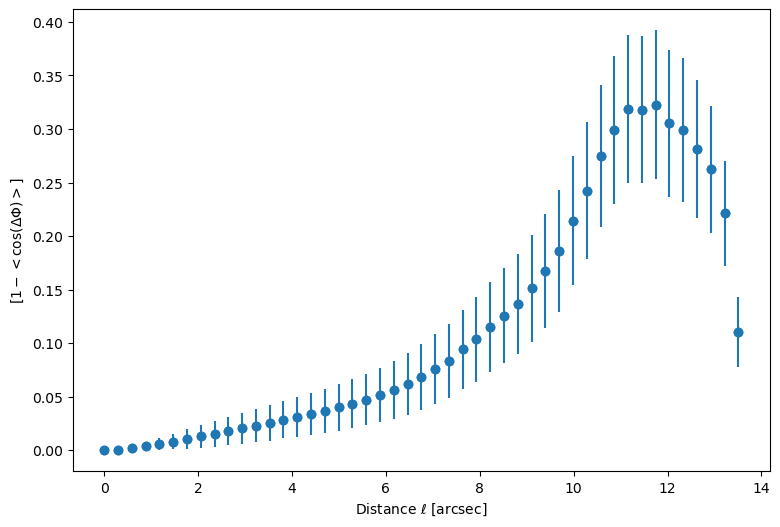

In [12]:
#ell_plot = ellbin[:len(ellbin)-1] + (ellbin[1] - ellbin[0])/2.0
ell_plot = ellbin[:len(ellbin)-1]
print(ell_plot)

dispersion_func = []
dispersion_func_err = []
# Averging within each bin 
for i in range(len(ell_plot)):
    mean_cos_deltaPA_bin = np.mean(cos_deltaPA_bin[i])
    correction = np.mean(cos_err_deltaPA_bin[i])
    mean_sin_deltaPA_bin = np.mean(sin_deltaPA_bin[i])
    mean_deltaPA_err_sqaure_bin = np.mean(deltaPA_err_sqaure_bin[i])
    mean_deltaPA_err_quad_bin = np.mean(np.array(deltaPA_err_sqaure_bin[i])**2)
    error_square_bin = (mean_sin_deltaPA_bin**2)*mean_deltaPA_err_sqaure_bin + (3.0/4.0)*(mean_cos_deltaPA_bin**2)*mean_deltaPA_err_quad_bin
    error_bin = np.sqrt(error_square_bin)

    dispersion_func.append(1.0-(mean_cos_deltaPA_bin/correction))
    dispersion_func_err.append(error_bin)

fig = plt.figure(figsize=(9,6))
plt.xlabel(r'$ \mathrm{Distance}^2\/\/ \ell^2\/\/ [\mathrm{arcsec}]$')
plt.ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
plt.scatter(ell_plot**2, dispersion_func)
plt.errorbar(ell_plot**2, dispersion_func, yerr=dispersion_func_err, fmt="o")
plt.savefig("fig/adf_dispersion_lsquare_H09err_full.pdf", transparent=True)
plt.show() 

fig = plt.figure(figsize=(9,6))
plt.xlabel(r'$ \mathrm{Distance}\/\/ \ell\/\/ [\mathrm{arcsec}]$')
plt.ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
plt.scatter(ell_plot, dispersion_func)
plt.errorbar(ell_plot, dispersion_func, yerr=dispersion_func_err, fmt="o")
plt.savefig("fig/adf_dispersion_l_H09err_full.pdf", transparent=True)
plt.show() 

### Case 2: Calculating measurement uncertainties by using uncertainty package which follows simplified linear error propagation

47
[ 0.          0.29368639  0.58737279  0.88105918  1.17474557  1.46843197
  1.76211836  2.05580475  2.34949115  2.64317754  2.93686393  3.23055033
  3.52423672  3.81792311  4.11160951  4.4052959   4.69898229  4.99266869
  5.28635508  5.58004147  5.87372787  6.16741426  6.46110065  6.75478705
  7.04847344  7.34215983  7.63584623  7.92953262  8.22321901  8.51690541
  8.8105918   9.10427819  9.39796459  9.69165098  9.98533737 10.27902376
 10.57271016 10.86639655 11.16008294 11.45376934 11.74745573 12.04114212
 12.33482852 12.62851491 12.9222013  13.2158877  13.50957409]
[0.0, 0.0006109083571219642, 0.0020835068924968114, 0.003783010349267313, 0.005689779586722232, 0.008128243268647362, 0.010464408818158355, 0.01302906634202361, 0.015458845510862185, 0.0178379528709508, 0.020486713390361566, 0.023113909260699228, 0.025688740252159947, 0.028546785337879466, 0.031025409387009262, 0.03416054036720906, 0.036884911951277854, 0.03998260085630312, 0.04352522476412324, 0.04712206336929747, 0.051

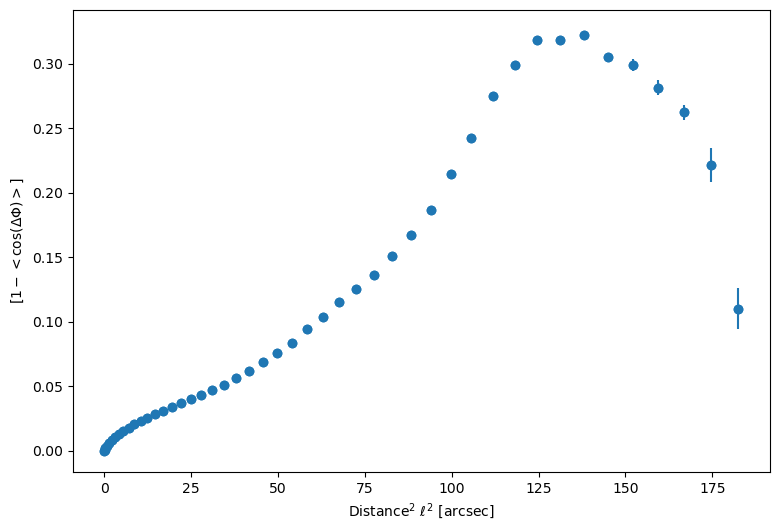

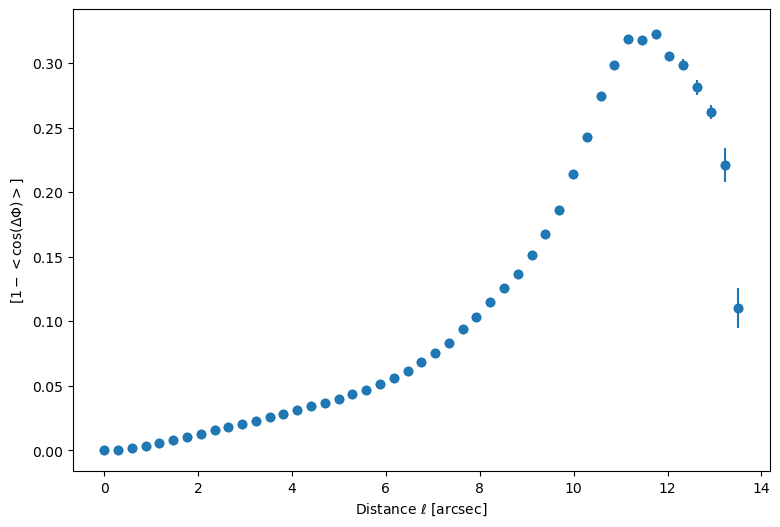

In [13]:
# binning PA and PAerr returned from uncertainty package
uncertainty_bin = value_binning(ellbin, ell, cosDeltaPhi_list)
print(len(uncertainty_bin))

dispersion_func_uncorrected = []
dispersion_func_uncer = []
dispersion_func_uncer_err = []
# Averging within each bin 
for i in range(len(ell_plot)):
    uncertainty_bin_uarray_n = []
    uncertainty_bin_uarray_s = []
    for j in range(len(uncertainty_bin[i])):
        uncertainty_bin_uarray_n.append(uncertainty_bin[i][j].n)
        uncertainty_bin_uarray_s.append(uncertainty_bin[i][j].s)
    
    uncertainty_bin_uarray = unp.uarray(uncertainty_bin_uarray_n, uncertainty_bin_uarray_s)
    mean_uncer_bin = uncertainty_bin_uarray.mean()
    correction = np.mean(cos_err_deltaPA_bin[i])
    dispersion_func_uncer_err.append(mean_uncer_bin.s/(correction**2))
    dispersion_func_uncorrected.append(mean_uncer_bin.n)
    dispersion_func_uncer.append(1.0-(mean_uncer_bin.n/correction))

print(ell_plot)
print(dispersion_func_uncer)
print(dispersion_func_uncer_err)

fig = plt.figure(figsize=(9,6))
plt.xlabel(r'$ \mathrm{Distance}^2\/\/ \ell^2\/\/ [\mathrm{arcsec}]$')
plt.ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
plt.scatter(ell_plot**2, dispersion_func_uncer)
plt.errorbar(ell_plot**2, dispersion_func_uncer, yerr=dispersion_func_uncer_err, fmt="o")
plt.savefig("fig/adf_dispersion_lsquare_linerr_full.pdf", transparent=True)
plt.show() 

fig = plt.figure(figsize=(9,6))
plt.xlabel(r'$ \mathrm{Distance}\/\/ \ell\/\/ [\mathrm{arcsec}]$')
plt.ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
plt.scatter(ell_plot, dispersion_func_uncer)
plt.errorbar(ell_plot, dispersion_func_uncer, yerr=dispersion_func_uncer_err, fmt="o")
plt.savefig("fig/adf_dispersion_l_linerr_full.pdf", transparent=True)
plt.show() 

### Calculating measurement uncertainties by using Houde's equation for sigma(delta phi) but used linear error propagation for <cos(delta phi)>

[ 0.          0.29368639  0.58737279  0.88105918  1.17474557  1.46843197
  1.76211836  2.05580475  2.34949115  2.64317754  2.93686393  3.23055033
  3.52423672  3.81792311  4.11160951  4.4052959   4.69898229  4.99266869
  5.28635508  5.58004147  5.87372787  6.16741426  6.46110065  6.75478705
  7.04847344  7.34215983  7.63584623  7.92953262  8.22321901  8.51690541
  8.8105918   9.10427819  9.39796459  9.69165098  9.98533737 10.27902376
 10.57271016 10.86639655 11.16008294 11.45376934 11.74745573 12.04114212
 12.33482852 12.62851491 12.9222013  13.2158877  13.50957409]
[0.0, 0.0006109083571228524, 0.0020835068935984857, 0.0037830103541428572, 0.005689779593813782, 0.00812824327275441, 0.010464408819569226, 0.01302906633305756, 0.015458845490571638, 0.01783795285965406, 0.02048671338242747, 0.023113909238769104, 0.02568874022427159, 0.02854678529333754, 0.031025409344937693, 0.03416054032930005, 0.03688491190448395, 0.03998260080800142, 0.043525224703773624, 0.04712206330812774, 0.05131351

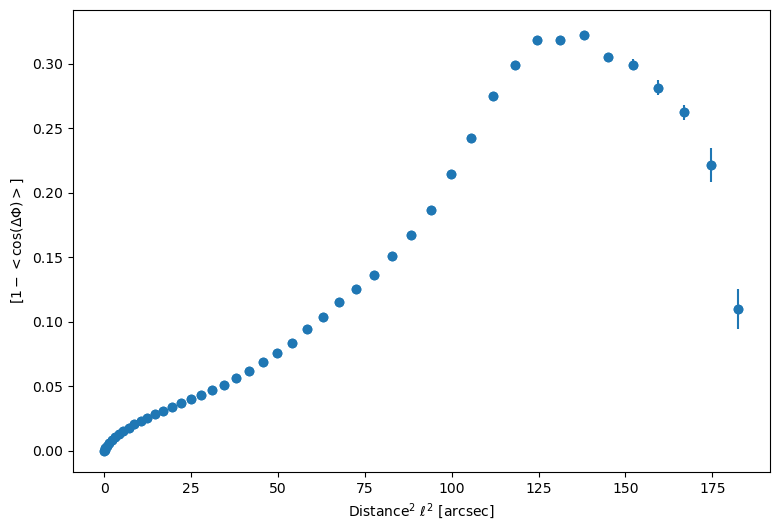

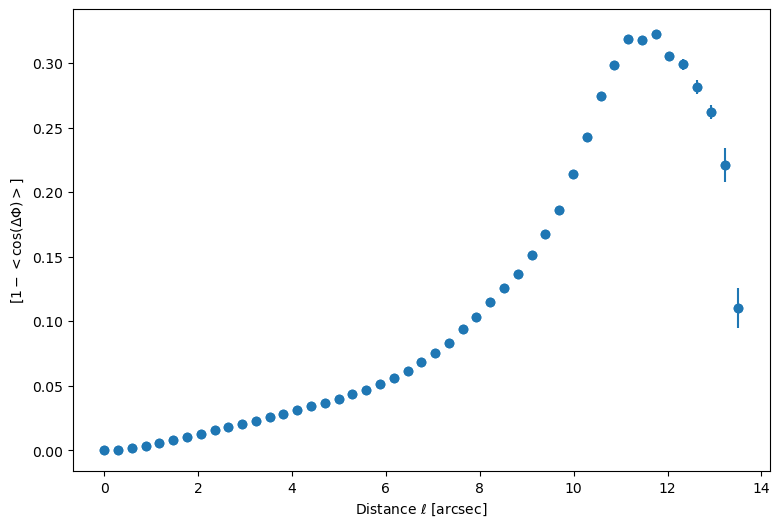

In [14]:
dispersion_func_linerr_anglecorr = []
dispersion_func_err_linerr_anglecorr = []
# Averging within each bin 
for i in range(len(ell_plot)):
    mean_cos_deltaPA_bin = np.mean(cos_deltaPA_bin[i])
    correction = np.mean(cos_err_deltaPA_bin[i])
    sigmaSquare_avgCos = np.sum(linerr_anglecorr_sigmaCosSquare_bin[i])/((len(linerr_anglecorr_sigmaCosSquare_bin[i]))**2)
    sigmaSquare_avgCos_correction = sigmaSquare_avgCos/(correction**2)

    dispersion_func_linerr_anglecorr.append(1.0-(mean_cos_deltaPA_bin/correction))
    dispersion_func_err_linerr_anglecorr.append(np.sqrt(sigmaSquare_avgCos_correction))

print(ell_plot)
print(dispersion_func_linerr_anglecorr)
print(dispersion_func_err_linerr_anglecorr)

fig = plt.figure(figsize=(9,6))
plt.xlabel(r'$ \mathrm{Distance}^2\/\/ \ell^2\/\/ [\mathrm{arcsec}]$')
plt.ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
plt.scatter(ell_plot**2, dispersion_func_linerr_anglecorr)
plt.errorbar(ell_plot**2, dispersion_func_linerr_anglecorr, yerr=dispersion_func_err_linerr_anglecorr, fmt="o")
plt.show() 

fig = plt.figure(figsize=(9,6))
plt.xlabel(r'$ \mathrm{Distance}\/\/ \ell\/\/ [\mathrm{arcsec}]$')
plt.ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
plt.scatter(ell_plot, dispersion_func_linerr_anglecorr)
plt.errorbar(ell_plot, dispersion_func_linerr_anglecorr, yerr=dispersion_func_err_linerr_anglecorr, fmt="o")
plt.show() 

# [0.0, 0.0006109083571219642, 0.0020835068924968114, 0.003783010349267313, 0.005689779586722232, 0.008128243268647362, 0.010464408818158355, 0.01302906634202361, 0.015458845510862185, 0.0178379528709508, 0.020486713390361566, 0.023113909260699228, 0.025688740252159947, 0.028546785337879466, 0.031025409387009262, 0.03416054036720906, 0.036884911951277854, 0.03998260085630312, 0.04352522476412324, 0.04712206336929747, 0.051313518258889856, 0.05634016827839061, 0.06172664111208259, 0.0686863007962083, 0.07579018754439759, 0.08349530680127015, 0.09416563867934769, 0.10355399063338144, 0.11506277159195966, 0.12570663261527992, 0.13642687177851565, 0.15126077762217527, 0.16736236525809012, 0.18627324107382437, 0.2144533761183588, 0.24249728828008887, 0.2748510498727096, 0.29900359905666196, 0.3184790711429125, 0.3181112033559802, 0.3225113686524871, 0.30539319058147774, 0.2990485623998772, 0.2814282517591514, 0.26227925403819397, 0.22129457482211812, 0.11022869064782004]
# [0.0, 7.822956992443325e-05, 9.692711411489042e-05, 0.00011055918776862638, 0.00012049205885771357, 0.00010960200763595789, 0.00012968772237035146, 0.0001268072322947016, 0.00013864498161080186, 0.0001438323992738011, 0.00013970149365105295, 0.00013401778953005624, 0.00015598238949695727, 0.00014631650799459847, 0.00016442782997694975, 0.0001540064871346154, 0.00017563442831535823, 0.00017593987949862373, 0.0001809779169679479, 0.00019074640773932933, 0.00020245557804070424, 0.0002072073023612104, 0.00022628598448160833, 0.0002466573435848848, 0.00027673863995384735, 0.000316492689932029, 0.00030463311128292185, 0.0003906153926787487, 0.00040254632272883865, 0.00046718563690703683, 0.0005278004095799988, 0.0005569248211508862, 0.0006863055584093205, 0.0008223448096884875, 0.0009176570522897535, 0.0012170408657777923, 0.0013814478198379337, 0.001666675656592849, 0.0020284445593091336, 0.002058542680203166, 0.0029446113128764754, 0.0029406464073801213, 0.004352322407567878, 0.005637295952462086, 0.005756479898284966, 0.013294912645584803, 0.015596666922737005]

### Fitting Houde 2009 and plotting errors from the 3 cases

The beam radius is 0.895112929391518 arcsec
The effective cloud depth is 10.5 arcsec
The sqaure of PA dispersion is fitted to be 2.503783147500688
delta is fitted to be 0.32265022729110826 arcsec
a' is fitted to be 0.001138916106379946 arcsec^-2


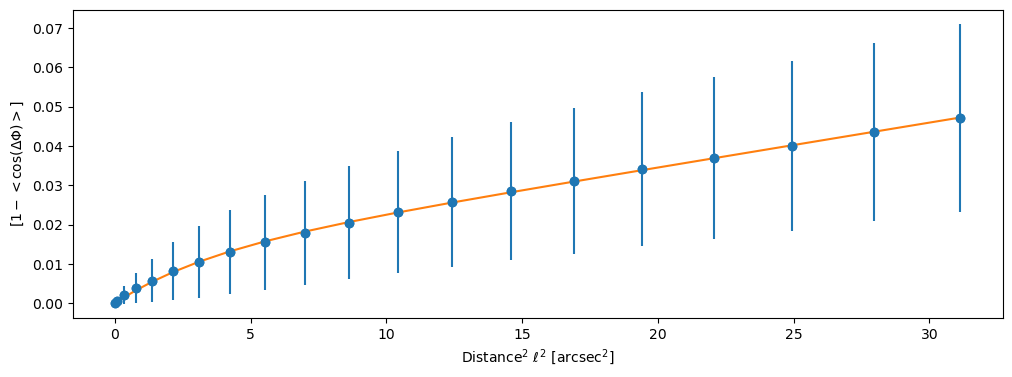

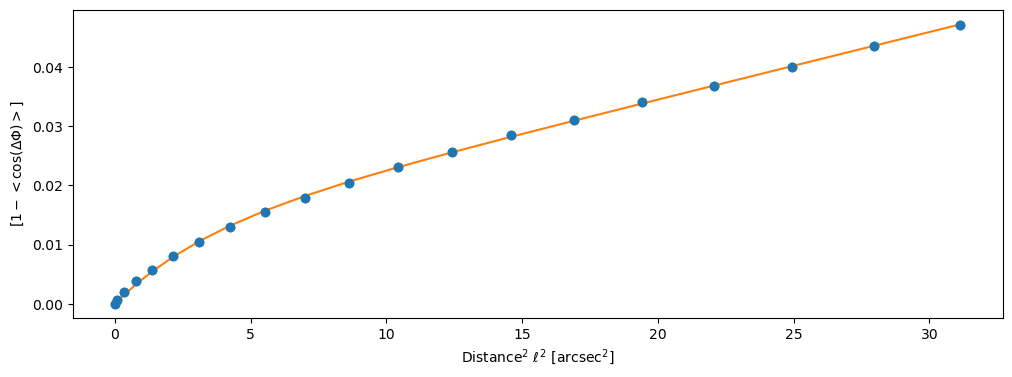

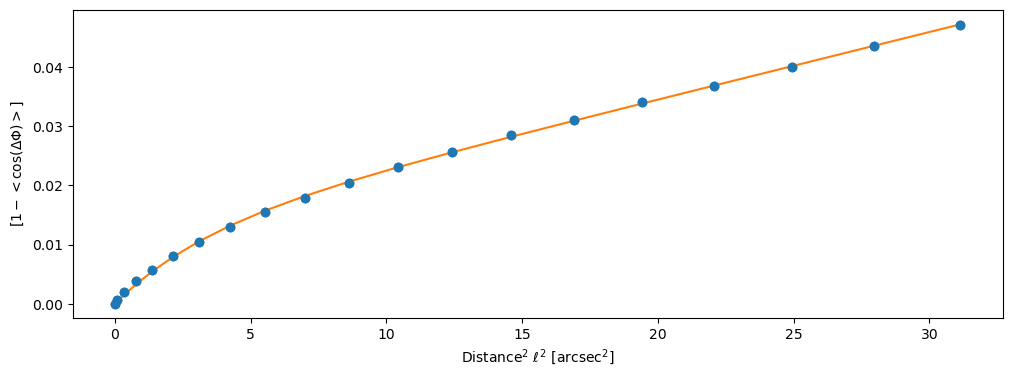

In [15]:
# extracting only the first 20 data points of the dispersion fucntion to do fitting 
data_num_start = 0
data_num = 20
ell_fit = ell_plot[data_num_start:data_num]
ell2_fit = ell_fit**2
# data and errors from case 2
avg_cos_deltaPA_fit = dispersion_func_uncer[data_num_start:data_num]
error_bar_fit = dispersion_func_uncer_err[data_num_start:data_num]
# data and errors from case 1
avg_cos_deltaPA_fit_H09err = dispersion_func[data_num_start:data_num]
error_bar_fit_H09err = dispersion_func_err[data_num_start:data_num]
# data and errors from case 3
avg_cos_deltaPA_fit_linerr_anglecorr = dispersion_func_linerr_anglecorr[data_num_start:data_num]
error_bar_fit_linerr_anglecorr = dispersion_func_err_linerr_anglecorr[data_num_start:data_num]

# beam radius W : geometric mean of the FWHM of the major and minor axis divided by sqrt(8ln2)
W = np.sqrt(PA.bmaj*deg_to_arcsec*PA.bmin*deg_to_arcsec)/np.sqrt(8*math.log(2))  # beam "radius"
Delta_prime = trial_distance #trial_distance # effective cloud depth

def correlation_func(ell2, delta, PAdispersion4, a_2_prime):
    correlation = np.sqrt(2*np.pi)*PAdispersion4*((delta**3)/((delta**2+2*W**2)*Delta_prime))*(1-np.exp((-ell2)/(2*(delta**2+2*W**2))))+a_2_prime*(ell2)
    return correlation

# simultaneously fitting all 3 parameters
parameters, covariance = curve_fit(correlation_func, ell2_fit, avg_cos_deltaPA_fit, maxfev=10000)
#parameters, covariance = curve_fit(correlation_func, ell2_fit, avg_cos_deltaPA_fit, bounds=([0.89, 0, 0], [9.8, 0.4, 1.]), maxfev=10000)

fit_delta = parameters[0]
fit_PAdispersion4 = parameters[1]
fit_a_2_prime = parameters[2]

print("The beam radius is", W, 'arcsec')
print("The effective cloud depth is", Delta_prime, 'arcsec')
print("The sqaure of PA dispersion is fitted to be", fit_PAdispersion4)
print("delta is fitted to be", fit_delta, 'arcsec')
print("a' is fitted to be", fit_a_2_prime, 'arcsec^-2')

correlation_func_fit = correlation_func(ell2_fit, fit_delta, fit_PAdispersion4, fit_a_2_prime)
fig = plt.figure(figsize=(12,4))
plt.xlabel(r'$ \mathrm{Distance}^2\/\/ \ell^2\/\/ [\mathrm{arcsec^2}]$')
plt.ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
plt.scatter(ell2_fit, avg_cos_deltaPA_fit_H09err)
plt.errorbar(ell2_fit, avg_cos_deltaPA_fit_H09err, yerr=error_bar_fit_H09err, fmt="o")
plt.plot(ell2_fit, correlation_func_fit, '-')
plt.savefig("fig/adf_dispersion_lsquare_H09err.pdf", transparent=True)
plt.show() 

correlation_func_fit = correlation_func(ell2_fit, fit_delta, fit_PAdispersion4, fit_a_2_prime)
fig = plt.figure(figsize=(12,4))
plt.xlabel(r'$ \mathrm{Distance}^2\/\/ \ell^2\/\/ [\mathrm{arcsec^2}]$')
plt.ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
plt.scatter(ell2_fit, avg_cos_deltaPA_fit)
plt.errorbar(ell2_fit, avg_cos_deltaPA_fit, yerr=error_bar_fit, fmt="o")
plt.plot(ell2_fit, correlation_func_fit, '-')
plt.savefig("fig/adf_dispersion_lsquare_linerr_package.pdf", transparent=True)
plt.show() 

correlation_func_fit = correlation_func(ell2_fit, fit_delta, fit_PAdispersion4, fit_a_2_prime)
fig = plt.figure(figsize=(12,4))
plt.xlabel(r'$ \mathrm{Distance}^2\/\/ \ell^2\/\/ [\mathrm{arcsec^2}]$')
plt.ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
plt.scatter(ell2_fit, avg_cos_deltaPA_fit_linerr_anglecorr)
plt.errorbar(ell2_fit, avg_cos_deltaPA_fit_linerr_anglecorr, yerr=error_bar_fit_linerr_anglecorr, fmt="o")
plt.plot(ell2_fit, correlation_func_fit, '-')
plt.savefig("fig/adf_dispersion_lsquare_linerr.pdf", transparent=True)
plt.show() 

### Fitting a straight line without the turbulent components

The slope is fitted to be 0.0011112586008550553
The x-intercept is fitted to be 0.012443317438562092


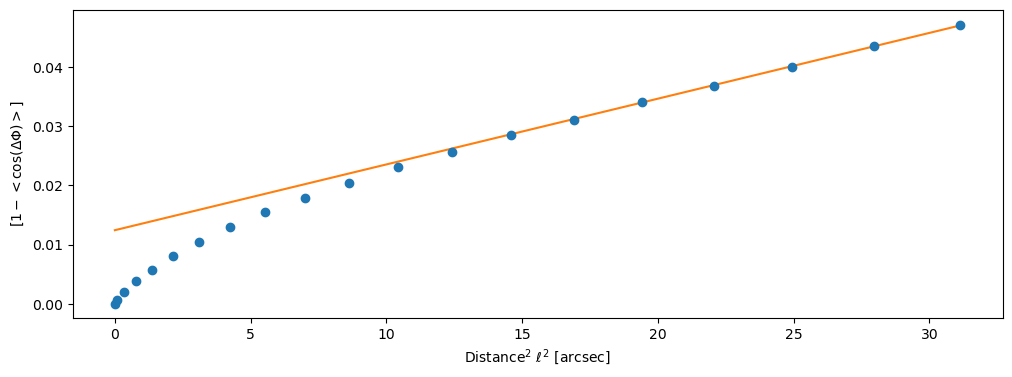

In [16]:
data_num_linear = data_num - 5
ell_linear_fit = ell_plot[data_num_linear:data_num]**2
avg_cos_deltaPA_linear_fit = dispersion_func[data_num_linear:data_num]
error_bar_linear_fit = dispersion_func_err[data_num_linear:data_num]

def linear_fuc(ell2, a_2_prime, c):
    linear = a_2_prime*ell2 + c
    return linear

parameters, covariance = curve_fit(linear_fuc, ell_linear_fit, avg_cos_deltaPA_linear_fit)

fit_slope = parameters[0]
fit_intercept = parameters[1]

print("The slope is fitted to be", fit_slope)
print("The x-intercept is fitted to be", fit_intercept)

linear_fuc_fit = linear_fuc(ell2_fit, fit_slope, fit_intercept)
fig = plt.figure(figsize=(12,4))
plt.xlabel(r'$ \mathrm{Distance}^2\/\/ \ell^2\/\/ [\mathrm{arcsec}]$')
plt.ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
#plt.scatter(ell2_fit, avg_cos_deltaPA_fit)
plt.errorbar(ell2_fit, avg_cos_deltaPA_fit, yerr=error_bar_fit, fmt="o")
plt.plot(ell2_fit, linear_fuc_fit, '-')
plt.show() 

### Producing the final 3 plots

The beam radius is 0.895112929391518 arcsec
The effective cloud depth is 10.5 arcsec
The sqaure of PA dispersion is fitted to be 0.10922522870922495
delta is fitted to be 1.3000000000000003 arcsec
a' is fitted to be 0.0009293804836007869 arcsec^-2


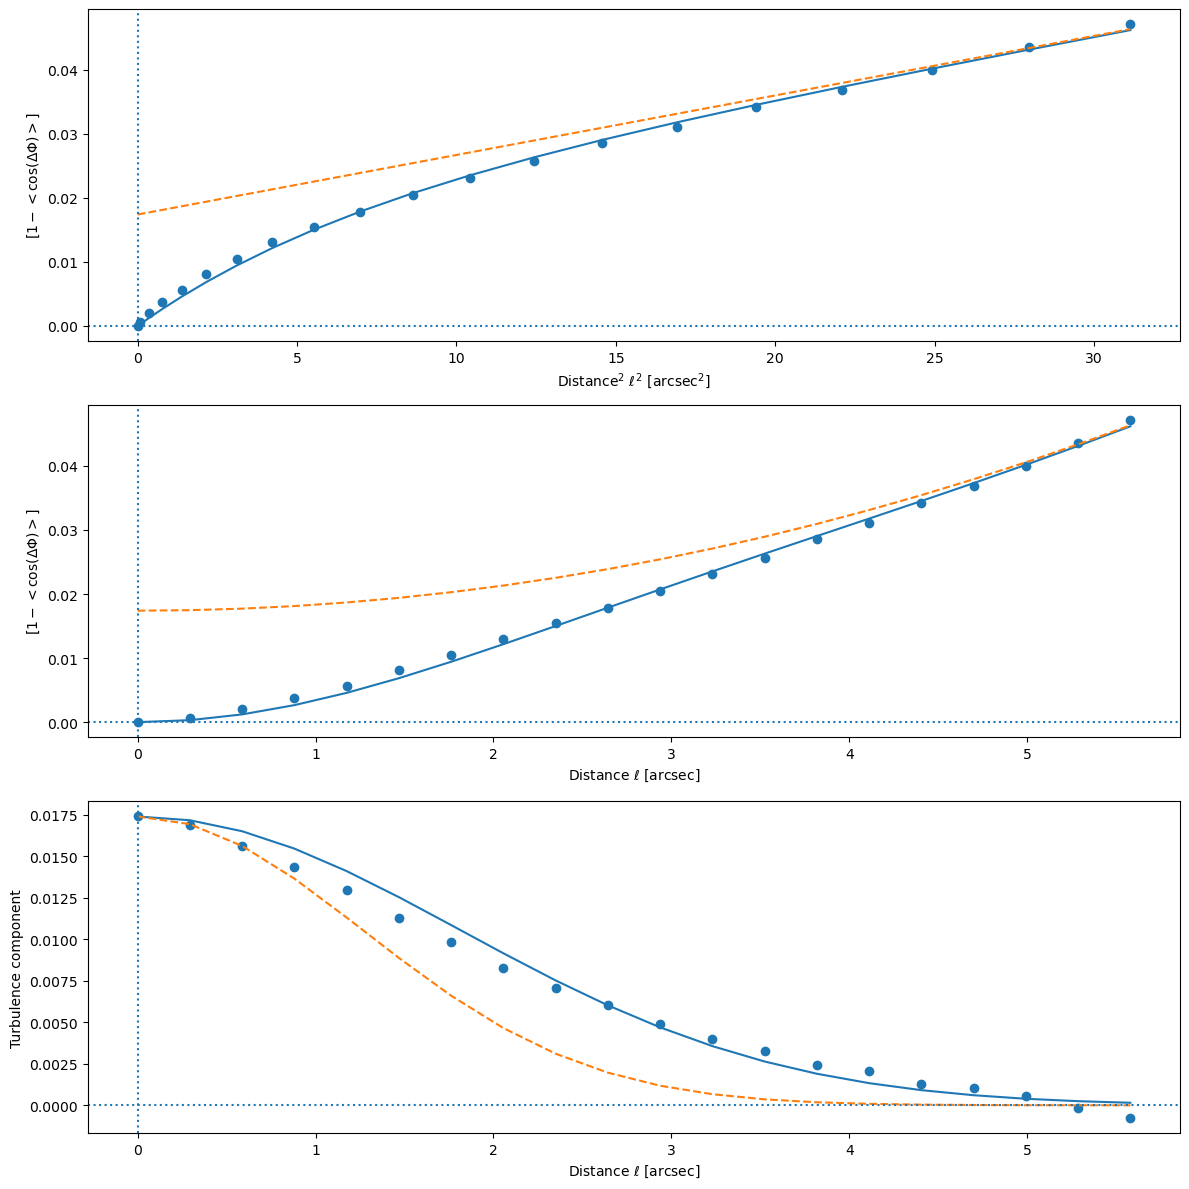

In [17]:
def correlation_func(ell2, delta, PAdispersion4, a_2_prime):
    correlation = np.sqrt(2*np.pi)*PAdispersion4*((delta**3)/((delta**2+2*W**2)*Delta_prime))*(1-np.exp((-ell2)/(2*(delta**2+2*W**2))))+a_2_prime*(ell2)
    return correlation

#simultaneously fitting all 3 parameters
parameters, covariance = curve_fit(correlation_func, ell2_fit, avg_cos_deltaPA_fit, 
                                   p0 = [3.5, 0.2, 0.0009251352070273765],
                                   bounds=([1.3 , 0., 0], [9.8 , 0.5, 1.]), maxfev=100000)

# parameters, covariance = curve_fit(correlation_func, ell2_fit, avg_cos_deltaPA_fit, 
#                                    p0 = [3, 0.006, 0.0009251352070273765], maxfev=100000)

fit_delta = parameters[0]
fit_PAdispersion4 = parameters[1]
fit_a_2_prime = parameters[2]

intercept = np.sqrt(2*np.pi)*fit_PAdispersion4*((fit_delta**3)/((fit_delta**2+2*W**2)*Delta_prime))

print("The beam radius is", W, 'arcsec')
print("The effective cloud depth is", Delta_prime, 'arcsec')
print("The sqaure of PA dispersion is fitted to be", fit_PAdispersion4)
print("delta is fitted to be", fit_delta, 'arcsec')
print("a' is fitted to be", fit_a_2_prime, 'arcsec^-2')
#print("The recovered intercept is", intercept, "with a percentage error of", (intercept-fit_intercept)*100/fit_intercept, "%")
#print(covariance)

# plotting everything
correlation_func_fit = correlation_func(ell2_fit, fit_delta, fit_PAdispersion4, fit_a_2_prime)
linear_fuc_fit = linear_fuc(ell2_fit, fit_a_2_prime, intercept)
turbulence = linear_fuc_fit - avg_cos_deltaPA_fit
b_square = np.sqrt(2*np.pi)*fit_PAdispersion4*((fit_delta**3)/((fit_delta**2+2*W**2)*Delta_prime))*np.exp((-ell2_fit)/(2*(fit_delta**2+2*W**2)))
b_square_beam = np.sqrt(2*np.pi)*fit_PAdispersion4*((fit_delta**3)/((fit_delta**2+2*W**2)*Delta_prime))*np.exp((-ell2_fit)/(2*(0**2+2*W**2)))

# Create a single figure object with subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

# First subplot
axs[0].set_xlabel(r'$ \mathrm{Distance}^2\/\/ \ell^2\/\/ [\mathrm{arcsec^2}]$')
axs[0].set_ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
axs[0].scatter(ell2_fit, avg_cos_deltaPA_fit)
# axs[0].errorbar(ell2_fit, avg_cos_deltaPA_fit, yerr=error_bar_fit, fmt="o")
axs[0].plot(ell2_fit, correlation_func_fit, '-')
axs[0].plot(ell2_fit, linear_fuc_fit, '--')
axs[0].axvline(x=0, linestyle=":")
axs[0].axhline(y=0, linestyle=":")

# Second subplot
axs[1].set_xlabel(r'$ \mathrm{Distance}\/\/ \ell\/\/ [\mathrm{arcsec}]$')
axs[1].set_ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
axs[1].scatter(ell_fit, avg_cos_deltaPA_fit)
# axs[1].errorbar(ell_fit, avg_cos_deltaPA_fit, yerr=error_bar_fit, fmt="o")
axs[1].plot(ell_fit, correlation_func_fit, '-')
axs[1].plot(ell_fit, linear_fuc_fit, '--')
axs[1].axvline(x=0, linestyle=":")
axs[1].axhline(y=0, linestyle=":")

# Third subplot
axs[2].set_xlabel(r'$ \mathrm{Distance}\/\/ \ell\/\/ [\mathrm{arcsec}]$')
axs[2].set_ylabel("Turbulence component")
axs[2].scatter(ell_fit, turbulence)
axs[2].plot(ell_fit, b_square, '-')
axs[2].plot(ell_fit, b_square_beam, '--')
axs[2].axvline(x=0, linestyle=":")
axs[2].axhline(y=0, linestyle=":")

# Adjust spacing between subplots
plt.tight_layout()

# Save the combined figure
plt.savefig("fig/combined_figures.pdf", transparent=True)

# Show the combined figure
plt.show()

### Fitting Houde 2016 without measurement uncertainty

The beam radius w1 is 0.8951129293915179 arcsec
The low-frequency filtering effect w2 is 32 arcsec
The effective cloud depth is 10.5 arcsec
The sqaure of PA dispersion is fitted to be 0.3947077297614915
delta is fitted to be 0.32264996186710493 arcsec
a' is fitted to be 0.0011389232193074706 unitless


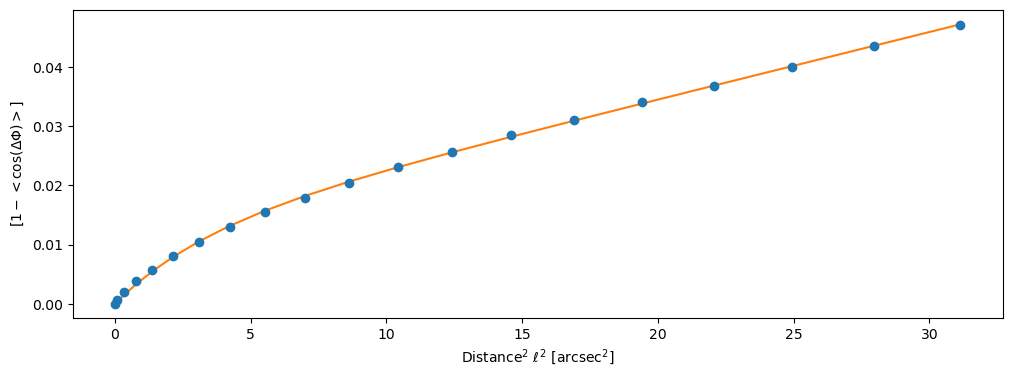

In [18]:
# extracting only the first 20 data points of the dispersion fucntion to do fitting 
data_num_start = 0
data_num = 20
ell_fit = ell_plot[data_num_start:data_num]
ell2_fit = ell_fit**2

# treating the two axes of the beam separately
w1 = np.sqrt(PA.bmaj*PA.bmin)*deg_to_arcsec/np.sqrt(8*math.log(2))
#w2 = PA.bmin*deg_to_arcsec/np.sqrt(8*math.log(2))
#w2 = 32/np.sqrt(8*math.log(2)) # JVLA 21A Q band D configuration theta_LAS https://science.nrao.edu/facilities/vla/docs/manuals/oss2021A/performance/resolution
w2 = 32

def correlation_func_interferometer(ell2, delta, PAdispersion4, sum_a_2_prime_ell2):
    ell2 = np.array(ell2, dtype=float)
    
    # Number of turbulent cells along the line of sight
    N1 = ((delta**2 + 2*w1**2)*Delta_prime)/(np.sqrt(2*np.pi)*delta**3)
    N2 = ((delta**2 + 2*w2**2)*Delta_prime)/(np.sqrt(2*np.pi)*delta**3)
    N12 = ((delta**2 + w1**2 + w2**2)*Delta_prime)/(np.sqrt(2*np.pi)*delta**3)
    N = ((1/N1) + (1/N2) - (2/N12))**(-1)
    
    fac1 = N/(1 + N*PAdispersion4)
    fac2 = (1/N1)*(1 - np.exp((-ell2)/(2*(delta**2 + 2*w1**2))))
    fac3 = (1/N2)*(1 - np.exp((-ell2)/(2*(delta**2 + 2*w2**2))))
    fac4 = (1/N12)*(1 - np.exp((-ell2)/(2*(delta**2 + w1**2 + w2**2))))
    correlation_interferometer = sum_a_2_prime_ell2*ell2 + fac1*(fac2 + fac3 - fac4)
    return correlation_interferometer

# simultaneously fitting all 3 parameters
parameters, covariance = curve_fit(correlation_func_interferometer, ell2_fit, avg_cos_deltaPA_fit, maxfev=1000000)
#parameters, covariance = curve_fit(correlation_func_interferometer, ell2_fit, avg_cos_deltaPA_fit, bounds=([0.9 , 0., 0], [9.8 , 0.5, 1.]), maxfev=1000000)

fit_delta_H16 = parameters[0]
fit_PAdispersion4_H16 = parameters[1]
fit_a_2_prime_H16 = parameters[2]

print("The beam radius w1 is", w1, 'arcsec')
print("The low-frequency filtering effect w2 is", w2, 'arcsec')
print("The effective cloud depth is", Delta_prime, 'arcsec')
print("The sqaure of PA dispersion is fitted to be", fit_PAdispersion4_H16)
print("delta is fitted to be", fit_delta_H16, 'arcsec')
print("a' is fitted to be", fit_a_2_prime_H16, 'unitless')

correlation_func_interferometer_fit = correlation_func_interferometer(ell2_fit, fit_delta_H16, fit_PAdispersion4_H16, fit_a_2_prime_H16)
fig = plt.figure(figsize=(12,4))
plt.xlabel(r'$ \mathrm{Distance}^2\/\/ \ell^2\/\/ [\mathrm{arcsec^2}]$')
plt.ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
plt.errorbar(ell2_fit, avg_cos_deltaPA_fit_linerr_anglecorr, yerr=error_bar_fit_linerr_anglecorr, fmt="o")
plt.plot(ell2_fit, correlation_func_interferometer_fit, '-')
plt.savefig("fig/adf_H16_dispersion_lsquare_linerr.pdf", transparent=True)
plt.show() 

# # simultaneously fitting all 3 parameters
# parameters, covariance = curve_fit(correlation_func, ell2_fit, avg_cos_deltaPA_fit, bounds=([0.4, 0, 0], [0.9, 0.2, 100.]), maxfev=1000000)

# fit_delta_H16 = parameters[0]
# fit_PAdispersion4_H16 = parameters[1]
# fit_a_2_prime_H16 = parameters[2]

# print("The minor beam radius w1 is", w1, 'arcsec')
# print("The major beam radius w2 is", w2, 'arcsec')
# print("The effective cloud depth is", Delta_prime, 'arcsec')
# print("The sqaure of PA dispersion is fitted to be", fit_PAdispersion4_H16)
# print("delta is fitted to be", fit_delta_H16, 'arcsec')
# print("a' is fitted to be", fit_a_2_prime_H16, 'unitless')

# correlation_func_interferometer_fit = correlation_func_interferometer(ell2_fit, fit_delta_H16, fit_PAdispersion4_H16, fit_a_2_prime_H16)
# fig = plt.figure(figsize=(12,4))
# plt.xlabel(r'$ \mathrm{Distance}^2\/\/ \ell^2\/\/ [\mathrm{arcsec^2}]$')
# plt.ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
# plt.errorbar(ell2_fit, avg_cos_deltaPA_fit_linerr_anglecorr, yerr=error_bar_fit_linerr_anglecorr, fmt="o")
# plt.plot(ell2_fit, correlation_func_interferometer_fit, '-')
# plt.savefig("fig/adf_H16_dispersion_lsquare_linerr.pdf", transparent=True)
# plt.show() 